# Visual data exploration: The The Metropolitan Museum of Art NYC
This notebook provides a visual exploration of The Metropolitan Museum of Art's Open Access Collection. We will examine the acquisition timeline, departmental distribution, artist demographics, and geographical origins of the artworks.

![image info](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Metropolitan_Museum_of_Art_%28The_Met%29_-_Central_Park%2C_NYC.jpg/2560px-Metropolitan_Museum_of_Art_%28The_Met%29_-_Central_Park%2C_NYC.jpg)

By Hugo Schneider - Flickr, CC BY-SA 2.0, https://commons.wikimedia.org/w/index.php?curid=97399557

## Imports, Data Loading and a First Look

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.data_transformers.enable('vegafusion')

# Load CSV file into a DataFrame
csv_file_path = 'MetObjects.csv'
df = pd.read_csv(csv_file_path, low_memory=False)

# Display the first few rows and the info to understand the structure
df.head()

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,1,NaN,The American Wing,1979,Coin,One-dollar Liberty Head Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,2,NaN,The American Wing,1980,Coin,Ten-dollar Liberty Head Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
2,67.265.9,False,False,False,3,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,67.265.10,False,False,False,4,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
4,67.265.11,False,False,False,5,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,NaN,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


The Datafile consists of 484,956 rows (entries) and 54 columns.
47 columns contain textual data (object), the others contain numeric data or boolean values. 

In [5]:
#view the missing values in ascending order
df.isna().sum().sort_values(ascending = False)

Metadata Date              484956
River                      482864
State                      482335
Locus                      477438
County                     476397
Reign                      473720
Locale                     469217
Excavation                 468385
Subregion                  462813
Dynasty                    461755
Rights and Reproduction    460427
Portfolio                  458442
Region                     453456
City                       452202
Gallery Number             435415
Geography Type             424997
Object Wikidata URL        415802
Country                    408949
Period                     393813
Artist Gender              378474
Tags                       292501
Tags AAT URL               292501
Tags Wikidata URL          292501
Culture                    276766
Artist Wikidata URL        260754
Artist ULAN URL            257515
Artist Display Bio         204533
Artist Suffix              202491
Artist End Date            202443
Artist Nationa

There are many gaps in the information on the artists. Half of the data records have missing values. Only some records are missing administrative information, such as Accession Year.

## The Art of Acquisition: An Exploration through Time and Departments

![image info](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Great_Hall_-_Metropolitan_Museum_of_Art_-_New_York_City_-_DSC07429.jpg/1599px-Great_Hall_-_Metropolitan_Museum_of_Art_-_New_York_City_-_DSC07429.jpg?20200227160302)

By Daderot - Own work, CC0, https://commons.wikimedia.org/w/index.php?curid=87506272

### Heatmap of the Accession of Artworks across Departments

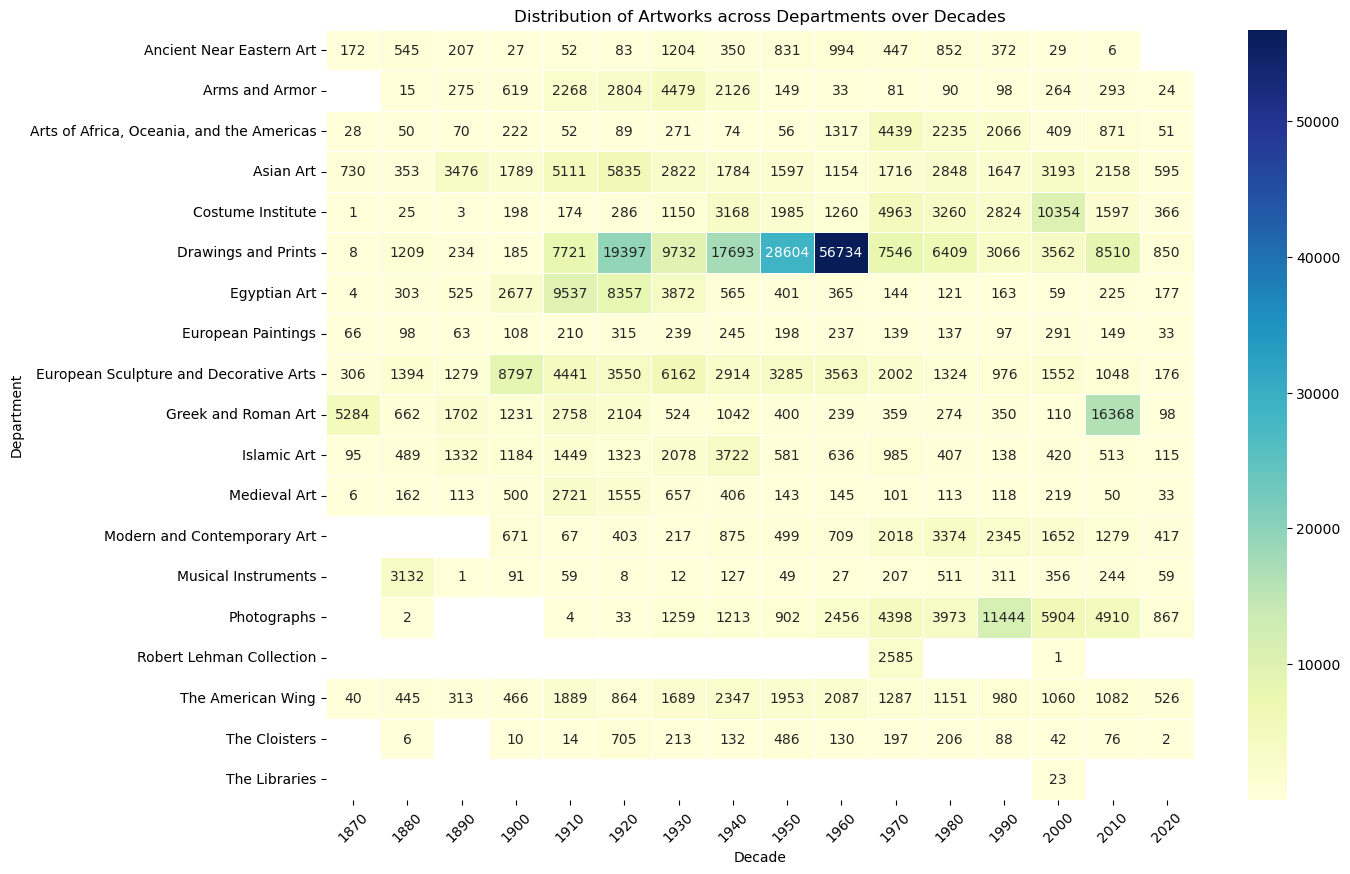

In [9]:
# Convert AccessionYear to numeric (if necessary)
df['AccessionYear'] = pd.to_numeric(df['AccessionYear'], errors='coerce').astype('Int64')

# Round AccessionYear to nearest decade and handle NaN values
df['Decade'] = (df['AccessionYear'] // 10) * 10

# Create pivot table for heatmap
heatmap_data = df.pivot_table(index='Department', columns='Decade', values='Object ID', aggfunc='count')

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)

# Adjust x-axis ticks to show decades as integers
plt.xticks(rotation=45)
plt.title('Distribution of Artworks across Departments over Decades')
plt.xlabel('Decade')
plt.ylabel('Department')
plt.show()

### Bar Chart Distribution of Artworks over all Departments

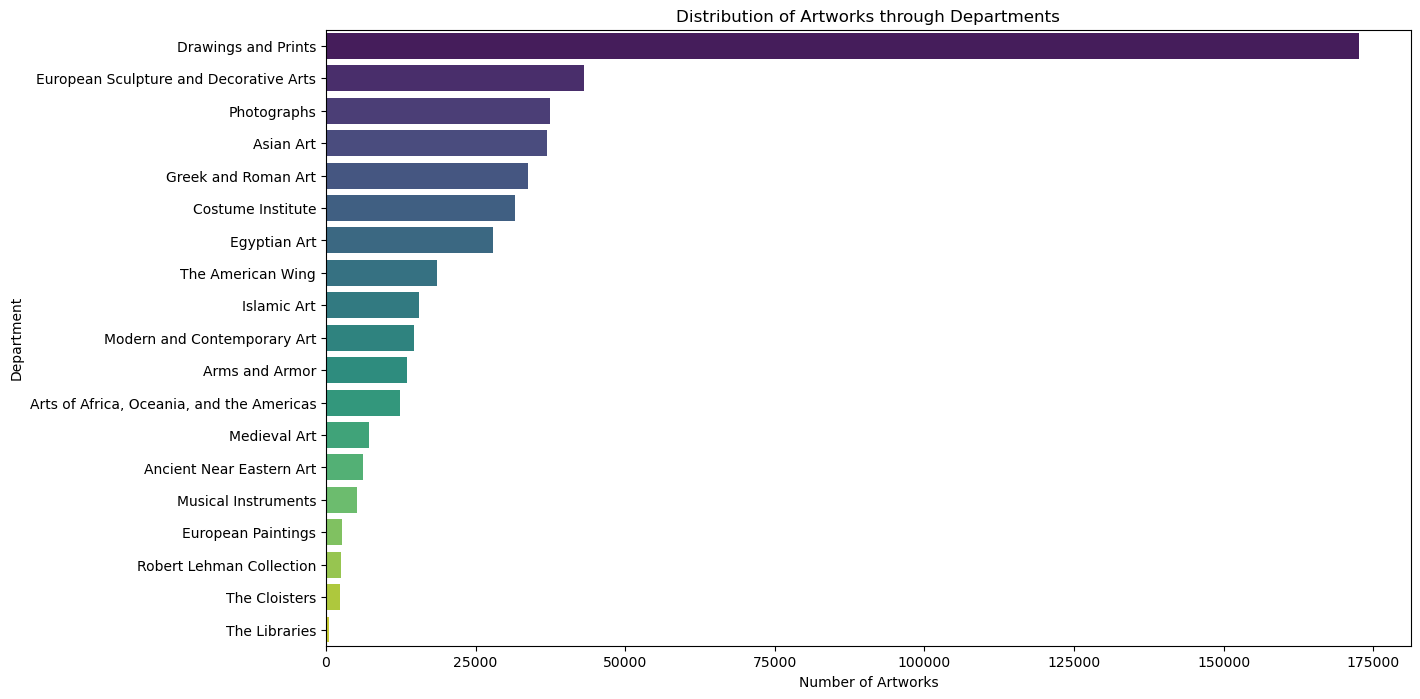

In [11]:
# Group by 'Department' and count the number of artworks
department_counts = df['Department'].value_counts()

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x=department_counts.values, y=department_counts.index, palette='viridis')
plt.title('Distribution of Artworks through Departments')
plt.xlabel('Number of Artworks')
plt.ylabel('Department')
plt.show()

The Drawings and Prints Collection is by far the largest. It is grouped together with the following departments, which are not labelled geographically:

- Photographs
- Costume Institute
- Modern and Contemporary Art
- Arms and Armor
- Musical Instruments
- Robert Lehmann Collection, which appears to be a private collection section
- The Cloisters
- The Libraries

Because of the different categorization of the departments, it is difficult to compare them, e.g. in terms of the geographical distribution of the works of art. For example, the largest department, Drawings and Prints, can include a wide range of nationalities. We will therefore look at artists and works of art in the following steps.

## Beyond the Brush: Get to Know the Artists

![image info](https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/At_the_Met%2C_Manhattan%2C_New_York%2C_13_Feb._2008_%282263987904%29.jpg/2560px-At_the_Met%2C_Manhattan%2C_New_York%2C_13_Feb._2008_%282263987904%29.jpg)

By Phillip Capper from Wellington, New Zealand - At the Met, Manhattan, New York, 13 Feb. 2008, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=133182181 

### Charts of Gender Representation

#### Preprocessing and Data Cleaning

In [16]:
def clean_gender_value(gender):
    if pd.isnull(gender):
        return 'Unknown'  # Handle NaN values as 'Unknown' or as needed
    
    # Convert to lowercase and strip whitespace
    gender = str(gender).lower().strip()  
    
    # Truncate unwanted patterns like 'i'
    gender = gender.replace('i', '')  
    
    # Check for desired gender categories
    if 'female' in gender and '|' in gender:
        return 'Female'
    elif 'male' in gender:
        return 'Male'
    else:
        return 'Unknown'  # Handle any other cases as 'Unknown' or specific cleaning as needed

# Create a new DataFrame df_gender with cleaned 'Artist Gender' column
df_gender = df.copy()  # Make a copy of original DataFrame

# Count the number of NaN values in 'Artist Gender'
num_nan = df_gender['Artist Gender'].isna().sum()

# Apply cleaning function to 'Artist Gender' column
df_gender['Artist Gender'] = df_gender['Artist Gender'].apply(clean_gender_value)

# Count the number of 'Unknown' values after cleaning
num_unknown = (df_gender['Artist Gender'] == 'Unknown').sum()

# Filter out rows where 'Artist Gender' is 'Unknown'
df_gender_clean = df_gender[df_gender['Artist Gender'] != 'Unknown']

# Display results of NaN / Unkown
print(f"Number of NaN entries in 'Artist Gender': {num_nan}")
print(f"Number of 'Unknown' entries after cleaning: {num_unknown}")

# Display unique values to verify
print(df_gender_clean['Artist Gender'].unique())

Number of NaN entries in 'Artist Gender': 378474
Number of 'Unknown' entries after cleaning: 470289
['Female' 'Male']


#### Visualisation

Number of unique artists: 7388


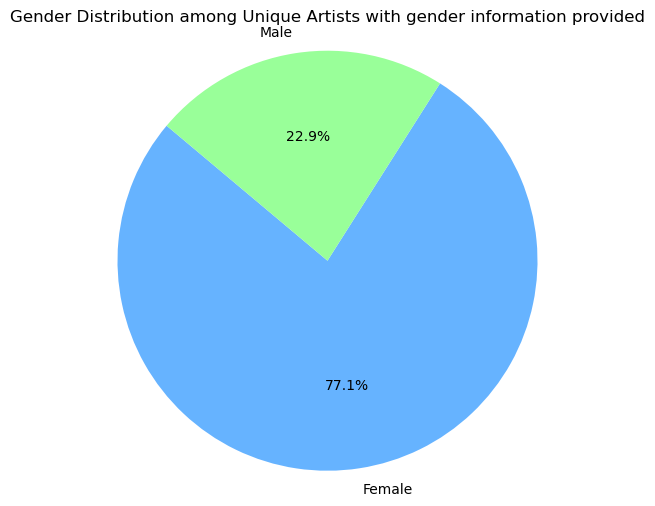

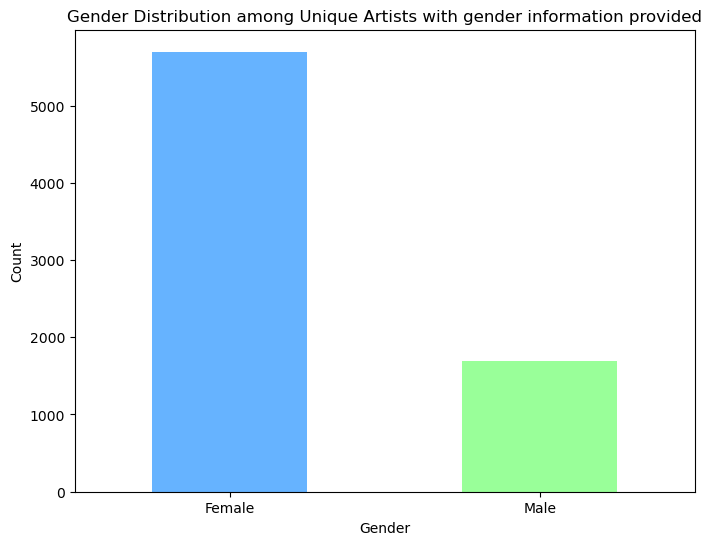

In [18]:
# Split 'Artist Display Name' by '|', expand into separate rows
artists_split = df_gender_clean['Artist Display Name'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('Artist Display Name')

# Create a new DataFrame with split artists
df_split_artists = df_gender_clean.drop('Artist Display Name', axis=1).join(artists_split)

# Group by artist names and keep the first gender value encountered
unique_artists = df_split_artists.drop_duplicates(subset=['Artist Display Name'], keep='first')

# Count values in 'Artist Gender' column after grouping
gender_counts = unique_artists['Artist Gender'].value_counts()

# Count number of unique artists
unique_artist_count = unique_artists['Artist Display Name'].nunique()
print("Number of unique artists:", unique_artist_count)

# Plotting pie chart
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Gender Distribution among Unique Artists with gender information provided')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Plotting bar chart
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color=['#66b3ff','#99ff99','#ffcc99'])
plt.title('Gender Distribution among Unique Artists with gender information provided')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Unfortunately, in 90% of the objects (470289) there is no valid information on the gender of the artist. Therefore, this visualization of the gender representation has no informative value. 

### Bar Chart of Nationality & Highlight Status

#### Preprocessing & Data Cleaning

In [22]:
# Count the number of NaN values in 'Nationality' in original df
num_nan_2 = df['Artist Nationality'].isna().sum()

# Count the number of NaN values in 'Artist Display Name' in original df
num_nan_3 = df['Artist Display Name'].isna().sum()

# Count the number of NaN values in 'Nationality' in Dataframe unique_artists
num_nan_4 = unique_artists['Artist Nationality'].isna().sum()

# Display results of NaN / Unkown
print(f"Number of NaN entries in 'Nationality' in original Dataframe: {num_nan_2}")
print(f"Number of NaN entries in 'Artist Display Name' in original Dataframe: {num_nan_3}")
print(f"Number of NaN entries in 'Nationality' among unique Artists: {num_nan_4}")

Number of NaN entries in 'Nationality' in original Dataframe: 202443
Number of NaN entries in 'Artist Display Name' in original Dataframe: 202443
Number of NaN entries in 'Nationality' among unique Artists: 0


For every artist we know, we also know their nationality. Of a total of 202443 works of art, we do not know the artist, and therefore also not his nationality.

In [26]:
# Print unique nationality values to inspect
unique_nationalities = unique_artists['Artist Nationality'].unique()
print("Unique Nationalities:")
print(unique_nationalities)

# Print unique Artist Display values to inspect
unique_names = unique_artists['Artist Display Name'].unique()
print("Unique Display Names:")
print(unique_names)

Unique Nationalities:
[' |American' 'American' 'American| ' 'French|American'
 'American|American and French' ' |German' 'American|American'
 'American|American and French|American' 'American|French'
 'British|American' 'Hungarian' 'British|British' 'American|British'
 ' |American| ' ' ' 'American| |American' 'American|American|American'
 ' | | | | | | | | | | | | | | | | |British| | | | | | |American'
 'American|American| ' 'American, born Lithuania|American'
 'American|Italian' 'Swiss' ' | | ' ' |American, born England| ' ' | '
 ' |American|American' 'American, born Austria|American, born Austria'
 'American, born Finland' ' | | |American' ' | |American' 'British'
 'Japanese' 'Chinese|Chinese' 'Chinese' 'Japanese|Japanese|Japanese'
 'Indian' 'British, born Taiwan' 'Italian' 'Japanese|Japanese' 'French'
 'Italian|Italian' 'Belgian' 'Italian|Italian|French'
 'French|French, born Germany|French' 'Japanese|American|Japanese'
 'French|French' 'Brazilian' 'French| ' 'Belgian|American'
 'Am

Some artists have several entries in the "Nationalities" field. We will separate these and count them individually.

In [31]:
# Function to clean nationality values with case normalization and splitting
def clean_nationality(nationality):
    if pd.isna(nationality) or nationality == '':
        return 'Unknown'
    cleaned = str(nationality).strip().lower()  # Convert to lowercase and strip whitespace
    # Remove unwanted characters and redundant delimiters
    cleaned = cleaned.replace("'", "").replace(",", "").replace("I", " ").replace("?", " ").replace("(", " ").replace(")", " ").replace("-", " ").replace("and", " ")  # Remove apostrophes, commas etc. and convert 'I' to space
    cleaned = cleaned.replace("|||||", "|").replace("|||", "|").replace("||", "|")
    # Split by pipe, strip spaces, remove empty parts, and join with '|'
    cleaned_list = [part.strip() for part in cleaned.split('|') if part.strip() and 'born' not in part]  # Exclude parts containing 'born'
    cleaned = '|'.join(cleaned_list)
    return cleaned

# Apply cleaning function and handle NaNs in 'Artist Nationality'
unique_artists.loc[:, 'Artist Nationality'] = unique_artists['Artist Nationality'].apply(clean_nationality)
unique_artists.loc[unique_artists['Artist Nationality'].isna(), 'Artist Nationality'] = 'Unknown'

# Expand nationalities into separate rows
expanded_rows = []
for index, row in unique_artists.iterrows():
    nationalities = row['Artist Nationality'].split('|')
    for nationality in nationalities:
        expanded_rows.append({'Artist Nationality': nationality, 'Is Highlight': row['Is Highlight']})

expanded_df = pd.DataFrame(expanded_rows)

# Display the unique values to inspect
print("Unique Nationalities:")
print(expanded_df['Artist Nationality'].unique())

Unique Nationalities:
['american' 'french' 'american   french' 'german' 'british' 'hungarian' ''
 'italian' 'swiss' 'japanese' 'chinese' 'indian' 'belgian' 'brazilian'
 'polish' 'spanish' 'italy' 'greek' 'austrian' 'danish'
 'french   american' 'finnish' 'british american' 'argentinian' 'dutch'
 'japanese american' 'russian' 'swedish' 'irish' 'canadian' 'australian'
 'british scottish' 'liechtensteiner' 'israeli' 'korean' 'mexican'
 'french active america' 'british welsh' 'cuban' 'mexican american'
 'iranian' 'inuit nunangat' 'first nation' 'javanese' 'nigerian'
 'native american' 'native american san ildefonso pueblo' 'malagasy'
 'flemish' 'portuguese' 'uruguayan' 'norwegian' 'chilean'
 'british or american' 'algerian' 'british london' 'bohemian'
 'netherl ish' 'british french' 'british   american' 'south african'
 'anglo irish' 'french   british' 'scottish' 'persian'
 'american   mexican' 'american   german' 'uruguayan american'
 'american scottish' 'romanian' 'american irish' 'czech

In [36]:
# Standardization dictionary
standardizations = {
    'us': 'american', 'america': 'american', 'united states': 'american', 'states': 'american', 'oklahoma': 'american',
    'france': 'french',
    'germany': 'german', 'leipzig': 'german',
    'spain': 'spanish',
    'ukraine': 'ukrainian',
    'israel': 'israeli',
    'britain': 'british', 'engl': 'british',  'london': 'british', 'brtiish': 'british', 'brtish': 'british', 'britsh': 'british',
    'uk': 'UK',
    'scotl': 'scottish', 'british scottish': 'scottish',
    'wales': 'welsh', 
    'lithuania': 'lithuanian',
    'hungary': 'hungarian',
    'austria': 'austrian',
    'russia': 'russian',
    'greece': 'greek',
    'italy': 'italian',
    'switzerl': 'swiss',
    'finl': 'finnish',
    'sweden': 'swedish',
    'latvia': 'latvian',
    'netherl s': 'dutch', 'netherl ish': 'dutch',
    'russia': 'russian',
    'korea': 'korean', 
    'iran': 'iranian',
    'canada': 'canadian', 'british columbia': 'canadian',
    'brazil': 'brazilian',
    'belgium': 'belgian',
    'denmark': 'danish',
    'poland': 'polish', 'pol': 'polish',
    'argentina': 'argentinian', 'argentine': 'argentinian',
    'mexico': 'mexican',
    'colombia': 'colombian',
    'venezuela': 'venezuelan',
    'puerto': 'puerto rican',
    'china': 'chinese',
    'india': 'indian',
    'ireland': 'irish', 'irel': 'irish',
    'japan': 'japanese', 'javanese': 'japanese',
    'czechoslovakia': 'czechoslovakian',
    'egypt': 'egyptian',
    'belgium': 'belgian',
    'chile': 'chilean',
    'unknown': 'unknown',
    'federal republic': 'unknown',
    'republic of': 'unknown',
    'united': 'unknown',
    'nation': 'unknown',
    'active': 'unknown',
    'first': 'First Nation',
    'rican': 'unknown',
    'native': 'native American',
    'san': 'unknown',
    'or': 'unknown',
    'south': 'south african',
    'african': 'unknown',
    'citizen': 'unknown'
}

# Function to standardize nationalities
def standardize_nationality(nationality):
    if nationality in standardizations:
        return standardizations[nationality]
    # Remove common non-nationality words
    for word in ['federal', 'republic', 'of', 'states', 'the']:
        nationality = nationality.replace(word, '').strip()
    return nationality

# Apply standardization function
expanded_df['Artist Nationality'] = expanded_df['Artist Nationality'].apply(standardize_nationality)

# Remove any remaining empty or unknown entries
expanded_df = expanded_df[expanded_df['Artist Nationality'] != '']

# Display the unique values to inspect
print("Unique Nationalities:")
print(expanded_df['Artist Nationality'].unique())

Unique Nationalities:
['american' 'french' 'american   french' 'german' 'british' 'hungarian'
 'italian' 'swiss' 'japanese' 'chinese' 'indian' 'belgian' 'brazilian'
 'polish' 'spanish' 'greek' 'austrian' 'danish' 'french   american'
 'finnish' 'british american' 'argentinian' 'dutch' 'japanese american'
 'russian' 'swedish' 'irish' 'canadian' 'australian' 'scottish'
 'liechtensteiner' 'israeli' 'korean' 'mexican' 'french active america'
 'british welsh' 'cuban' 'mexican american' 'iranian' 'inuit nunangat'
 'first nation' 'nigerian' 'native american'
 'native american san ildefonso pueblo' 'malagasy' 'flemish' 'portuguese'
 'uruguayan' 'norwegian' 'chilean' 'british or american' 'algerian'
 'british london' 'bohemian' 'british french' 'british   american'
 'south african' 'anglo irish' 'french   british' 'persian'
 'american   mexican' 'american   german' 'uruguayan american'
 'american scottish' 'romanian' 'american irish' 'czech' 'dutch british'
 'new zeal er' 'ukrainian' 'canadian  

#### Visualisation

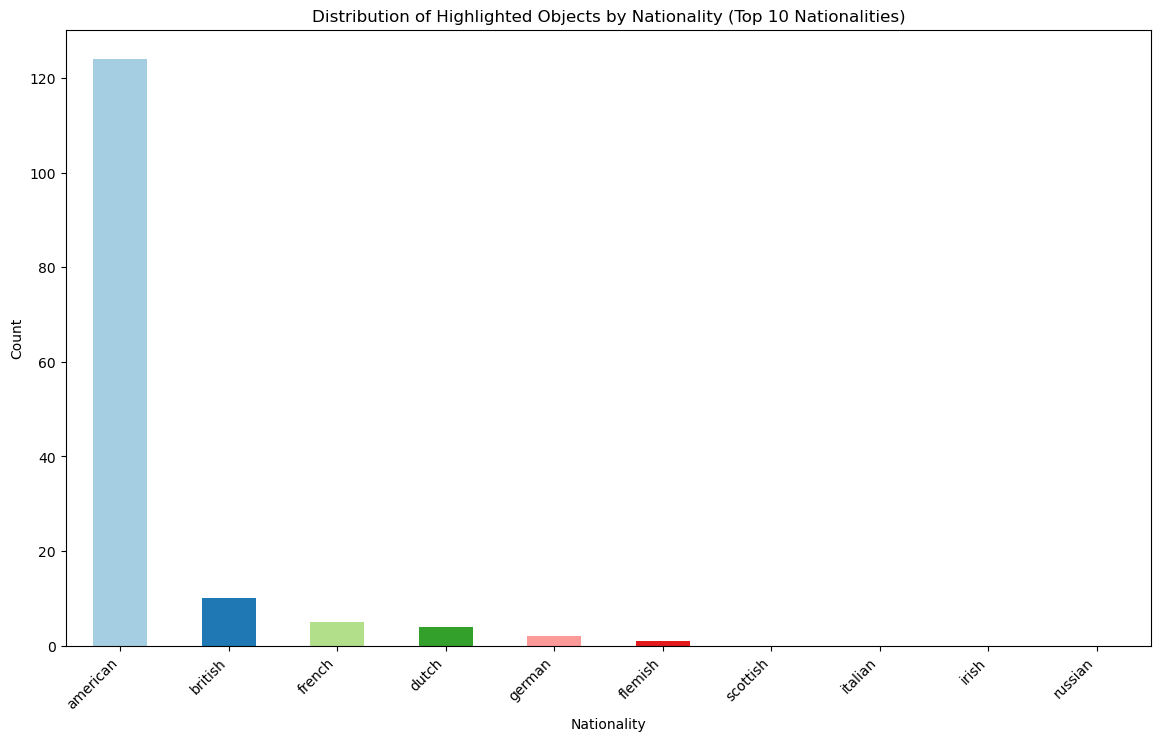

In [39]:
# Filter out 'Unknown' and empty nationalities
filtered_df = expanded_df[(expanded_df['Artist Nationality'] != 'unknown') & (expanded_df['Artist Nationality'] != '')]

# Determine the top 10 nationalities by count
top_nationalities = filtered_df['Artist Nationality'].value_counts().nlargest(10).index

# Filter the DataFrame to only include highlighted rows with the top 10 nationalities
highlighted_df = filtered_df[(filtered_df['Is Highlight'] == True) & (filtered_df['Artist Nationality'].isin(top_nationalities))]

# Count the number of highlighted objects by nationality
count_data = highlighted_df['Artist Nationality'].value_counts().reindex(top_nationalities)

# Sort count_data in descending order by count
count_data = count_data.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(14, 8))
count_data.plot(kind='bar', color=sns.color_palette("Paired", len(count_data)))
plt.title('Distribution of Highlighted Objects by Nationality (Top 10 Nationalities)')
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend().remove()  # Remove legend
plt.show()

The highlighted artworks in the collection are mostly by artists of American or European heritage.

#### Preprocessing and Data Cleaning - Cultures

In [43]:
# Display the unique values to inspect
print("Unique Cultures:")
print(df['Culture'].dropna().unique())

Unique Cultures:
['Mexican' 'Guatemalan' 'American' ... 'English, French'
 'English, probably London' 'Mexican or Argentinian']


Some artworks have several entries, or entries with more than just the culture mentioned in the "Culture" field. 

In [46]:
# Create a new DataFrame df_geo
df_geo = df.copy()

# Replace NaN values with an empty string in 'Culture' column
df_geo['Culture'] = df_geo['Culture'].fillna('')

# Normalize cultures to lower case to make processing easier
df_geo['Culture'] = df_geo['Culture'].str.lower()

# Replace inconsistent separators with a common separator (e.g., ', ')
df_geo['Culture'] = df_geo['Culture'].str.replace(' or ', ', ')
df_geo['Culture'] = df_geo['Culture'].str.replace(' and ', ', ')
# Add more replacements as needed based on your observations of the data

# Split multiple cultures into separate rows
df_geo = df_geo.assign(Culture=df_geo['Culture'].str.split(', ')).explode('Culture')

# Count occurrences of each culture
culture_counts = df_geo['Culture'].value_counts()

# Sort cultures by count in descending order
sorted_cultures = culture_counts.index.tolist()

# Display the sorted unique values
print("Sorted Cultures (most named first):")
print(sorted_cultures)

Sorted Cultures (most named first):
['', 'american', 'french', 'greek', 'attic', 'japan', 'china', 'italian', 'british', 'german', 'japanese', 'roman', 'european', 'cypriot', 'spanish', 'chinese', 'paris', 'coptic', 'london', 'dutch', 'etruscan', 'staffordshire', 'indian', 'iran', 'sasanian', 'austrian', 'russian', 'flemish', 'mexican', 'meissen', 'venice', 'frankish', 'minoan', 'swiss', 'south italian', 'indonesia (java)', 'moche', 'asmat people', 'india', 'sèvres', 'probably french', 'korea', 'byzantine', 'middle eastern', 'probably american', 'belgian', 'for american market', 'irish', 'assyrian', 'possibly french', 'south netherlandish', 'thailand', 'babylonian', 'paracas', 'venice (murano)', 'naples', 'florence', 'augsburg', 'turkish', 'peruvian', 'worcester', 'apulian', 'chimú', 'chelsea', 'lydian', 'tibet', 'probably european', 'brussels', 'british (american market)', 'birmingham', 'kwoma', 'eastern mediterranean', 'vienna', 'laconian', 'javanese', 'possibly german', 'italic', 'r

The values in the Cultures column diverse and difficult to assign to countries. 

Reasons for this include the following:
- Partial Information: The information often includes regions or ethnicities instead of specific countries
- Uncertainty: Many entries use phrases like "probably" or "possibly" indicating a lack of certainty about the origin
- Historical Context: Some entries mention historical names or regions that might not correspond directly to modern-day countries

## Art for All: Diving into MET's Public Domain Collection

![image info](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/New_York._Metropolitan_Museum_of_Art_%282800442785%29.jpg/1920px-New_York._Metropolitan_Museum_of_Art_%282800442785%29.jpg?20140418125153)

By Tomás Fano - New York. Metropolitan Museum of Art, CC BY-SA 2.0, https://commons.wikimedia.org/w/index.php?curid=32240824

## Stacked Bar Chart of Public Domain Artworks across Departments

#### Preprocessing

In [55]:
# Calculate counts of public domain and non-public domain artworks per department
counts = df.groupby(['Department', 'Is Public Domain']).size().reset_index(name='Count')

# Pivot to get public domain and non-public domain counts as separate columns
pivot_counts = counts.pivot(index='Department', columns='Is Public Domain', values='Count').fillna(0).reset_index()

pivot_counts.head()

Is Public Domain,Department,False,True
0,Ancient Near Eastern Art,33,6190
1,Arms and Armor,6542,7081
2,"Arts of Africa, Oceania, and the Americas",5997,6370
3,Asian Art,5705,31295
4,Costume Institute,23338,8314


In [56]:
# Melt the DataFrame to long format for easier plotting
pivot_melted = pd.melt(pivot_counts, id_vars='Department', var_name='Is Public Domain', value_name='Count')

print(pivot_melted)

                                   Department Is Public Domain   Count
0                    Ancient Near Eastern Art            False      33
1                              Arms and Armor            False    6542
2   Arts of Africa, Oceania, and the Americas            False    5997
3                                   Asian Art            False    5705
4                           Costume Institute            False   23338
5                         Drawings and Prints            False  107217
6                                Egyptian Art            False   15700
7                          European Paintings            False     299
8      European Sculpture and Decorative Arts            False    9257
9                         Greek and Roman Art            False    3849
10                                Islamic Art            False    2347
11                               Medieval Art            False     222
12                Modern and Contemporary Art            False   14493
13    

#### Visualisation

In [58]:
# Plotting the stacked bar chart
bars = alt.Chart(pivot_melted).mark_bar().encode(
    y=alt.Y('Department:N', title='Department'),
    x=alt.X('Count:Q', title='Number of Artworks'),
    color=alt.Color('Is Public Domain:N', legend=alt.Legend(title="Public Domain")),
    tooltip=['Department', 'Is Public Domain', 'Count']
).properties(
    title='Artworks in Public Domain vs Not Public Domain by Department',
    width=800,
    height=500
)

bars

alt.Chart(...)

The largest collection of artworks (Drawings and Prints) also contains the largest collection of public domain artworks. The proportion of public domain works of art is particularly high in the following departments: 

- Ancient Near Eastern Art
- Asian Art
- European Sculpture and Decorative Arts
- Greek and Roman Art
- Medieval Art
- The American Wing

The lowest proportion of public domain works is in the photography department. This makes sense, as photography is a young form of art compared to medieval or even Roman art. It has only been around since the 19th century. Therefore, many photographs are still subject to copyright and cannot be in the public domain.

### Heatmap Relation of Medium and Public Domain

In [74]:
# Step 1: Filter to include only the top 10 mediums
top_10_mediums = df['Medium'].value_counts().head(10).index
filtered_df = df[df['Medium'].isin(top_10_mediums)]

# Step 2: Aggregate counts by Medium and Is Public Domain
heatmap_data2 = filtered_df.groupby(['Medium', 'Is Public Domain']).size().reset_index(name='Count')

# Step 3: Create the heatmap using Altair
heatmap2 = alt.Chart(heatmap_data2).mark_rect().encode(
    x=alt.X('Medium:O', title='Medium', axis=alt.Axis(labelAngle=-45)),  # Rotate x-axis labels
    y=alt.Y('Is Public Domain:N', title='Is Public Domain', sort=['True', 'False']),
    color=alt.Color('Count:Q', title='Count'),
    tooltip=['Medium', 'Is Public Domain', 'Count']
).properties(
    title='Relation between Top 10 Mediums and Is Public Domain',
    width=800,
    height=400
)

heatmap2

alt.Chart(...)